In [40]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Layer Norm by hand
- Fill in the Layer Norm application below. Make sure the manual and PyTorch implementations are the same.
- As before, FILL_IN the missing code to make this work.

In [41]:
FILL_IN = "FILL_IN"

In [42]:
# This is (N, T, d_model)
# N: batch size
# T: sentence_length
# d_model: embedding dimension

N, T, d_model = 2, 3, 4

# An embedding. This is what you might feed into a network.
embedding = torch.randn(N, T, d_model)

# Create a Layer Norm layer on the embedding dimension.
# Do not include gamma and beta, the learnable scaling and offset parameters.
# This should act of the dimenson of the model.
layer_norm = nn.LayerNorm(d_model)
# Run embedding through the layer_norm layer.
layer_norm_pytorch = layer_norm(embedding)

# Manual computation; use the same EPSILON as is used in the standard nn.LayerNorm.
EPSILON = 1e-5

# Grab the mean of each vector in the first batch. This should be (3, 1).
mean = torch.mean(embedding[0],dim=1).unsqueeze(1)
# Grab the var of each vector in the first batch. This should be (3, 1).
var = torch.var(embedding[0],dim=1, unbiased=False).unsqueeze(1)
# Manually take each vector in the batch and standerdize it.
layer_norm_manual = (embedding[0]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 0: ", layer_norm_manual)
print("layer_norm_out[0]: ", layer_norm_pytorch[0])
assert torch.allclose(layer_norm_pytorch[0], layer_norm_manual), 'Tensors do not match.'

mean = torch.mean(embedding[1],dim=1).unsqueeze(1)
var = torch.var(embedding[1],dim=1, unbiased=False).unsqueeze(1)
layer_norm_manual = (embedding[1]-mean)/torch.sqrt(var+EPSILON)
print("layer_norm_manual @ 1: ", layer_norm_manual)
print("layer_norm_out[1]: ", layer_norm_pytorch[1])
assert torch.allclose(layer_norm_pytorch[1], layer_norm_manual), 'Tensors do not match.'

layer_norm_manual @ 0:  tensor([[ 0.5297,  1.0334,  0.0639, -1.6271],
        [ 1.2120, -1.0253,  0.7617, -0.9484],
        [ 0.3230,  1.0781, -1.6364,  0.2354]])
layer_norm_out[0]:  tensor([[ 0.5297,  1.0334,  0.0639, -1.6271],
        [ 1.2120, -1.0253,  0.7617, -0.9484],
        [ 0.3230,  1.0781, -1.6364,  0.2354]], grad_fn=<SelectBackward0>)
layer_norm_manual @ 1:  tensor([[ 0.8545,  0.2469, -1.6914,  0.5900],
        [-0.0584, -1.0112,  1.6307, -0.5611],
        [-0.1638, -0.5276, -0.9688,  1.6602]])
layer_norm_out[1]:  tensor([[ 0.8545,  0.2469, -1.6914,  0.5900],
        [-0.0584, -1.0112,  1.6307, -0.5611],
        [-0.1638, -0.5276, -0.9688,  1.6602]], grad_fn=<SelectBackward0>)


### Wave Net

In [43]:
# Hyperparameters we will use.                                                                                                                                                          
batch_size = 128 # How many independent sequences will we process in parallel?                                                                                              
context_size = 256 # What is the maximum context length for predictions? This is T below.                                                                                                    
epochs = 5000
eval_interval = 500
# Is this a good one? Can you check?
learning_rate = 3e-3
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
eval_iters = 200
d_model = 20
d_hidden = 100
n_layer = 1
dropout = 0.2
write_to_file = False
norm = 'batch_norm'

# Add more pritning to the model.
debug = False
# ------------        

In [44]:
torch.manual_seed(1337)

# Load the Shakespere document input.txt.                                                                          
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [45]:
# Get all the unique characters in the text.                                                                                                             
chars = list(set(text))
vocab_size = len(list(set(text)))
# As usual, create a mapping from a character to a text.                                                                                                                            
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x:[stoi[e] for e in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode = lambda x:''.join(itos[e] for e in x)

In [46]:
# Do a train-test split with 90% of the data train and 10% test.
# You can just use the first 90% of the data as training data.
# Run the text through the encode method.
data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n:]


In [47]:
# Load the data.
# This should return a small batch of data (x, y) where x is 
def get_batch(split):
    # Generate a small batch of data of inputs x and targets y.
    # Pick the train data if split == 'train', else the validation data.
    data = train_data if split == 'train' else val_data
    # Select a random set of ints [0, len(data) - context_size) ; reshape this to be (batch_size, )
    # For an index i, a x should be data[i:i+context_size] while a y should be data[i+context_size].
    # ix has length batch_size.
    ix = torch.randint(0,len(data) - context_size, (batch_size, ))
    # Stack the batch_size data to be of shape (batch_size, context_size)
    x = torch.tensor([data[i.item():i.item()+context_size] for i in ix])
    # Stack the y targets; this should be of length batch_size.
    # You should pull out the i+context_size element of data; i is an index in ix.
    y = torch.tensor([data[i.item()+context_size] for i in ix])                                                                          
    x, y = x.to(device), y.to(device)
    return x, y

In [48]:
# Estimate the loss.

@torch.no_grad()
def estimate_loss():
    out = {}
    # Put the model in eval mode. Why?
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(split)
            logits, loss = model(xb, yb)
            # Get the value in the loss.
            losses[k] = loss.item()
        # Get the mean of the values in the losses.
        out[split] = losses.mean().item()
    # Put the model in train mode.
    model.train()
    return out

In [49]:
class WaveNetMLPLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        
        self.linear_layers = []
        self.norm_layers = []
        self.linear_layers_res = []

        temp_context_size = context_size
        
        while temp_context_size >= 10:
            # Map from 2 * d_model to d_hidden.
            if not self.linear_layers:
                # Add to linear_layers a layer going 2 * d_model to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_model, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_model, d_hidden))
            else:
                # Map from 2 * d_hidden to d_hidden.
                # Add to linear_layers a layer going 2 * d_hidden to d_hidden.
                self.linear_layers.append(nn.Linear(2*d_hidden, d_hidden))
                self.linear_layers_res.append(nn.Linear(2*d_hidden, d_hidden))
            # Append to norm_layers a batch norm 1d with vectors of size d_hidden.
            self.norm_layers.append(nn.BatchNorm1d(d_hidden))
            # LayerNorm
            # self.norm_layers.append(nn.LayerNorm([d_hidden, temp_context_size//2]))
            
            temp_context_size //= 2
        
        self.linear_layers = nn.ModuleList(self.linear_layers)
        self.linear_layers_res = nn.ModuleList(self.linear_layers_res)
        self.norm_layers = nn.ModuleList(self.norm_layers)
        # Add a final batch norm 1d with vectors of size vocab_size. 
        self.norm_f = nn.BatchNorm1d(vocab_size) # Final layer norm.
        # Add a Linear layer going from temp_context_size * d_hidden to vocab_size.
        self.ff = nn.Linear(temp_context_size * d_hidden, vocab_size, bias=False)
        
    def forward(self, idx, targets=None):
        N, T = idx.shape

        # idx and targets are both (N, T) tensor of integers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
        x = self.token_embedding_table(idx) # (N, T, d_model)
        
        for i, _ in enumerate(self.linear_layers):
            N, T, D = x.shape
            # Reshape x to be (N, ??). You want to shrink the context window down by two each time.
            x = x.reshape(N, T//2, D * 2)
            # Residual Connection
            # residual = x    
            # Pass through linear layer i.
            x_res = self.linear_layers_res[i](x)
            x = self.linear_layers[i](x)
            # Transpose appropriate dimensions of x. Look at the expected dimensions of BatchNorm1d.
            x = x.transpose(1,2)
            # Pass through the batch norm layer.
            x = self.norm_layers[i](x)
            # Transpose back to the previous dimensions.
            x = x.transpose(1,2)
            # Pass through ReLU.
            # x = x.relu()
            # Residual Connection

            x = x.relu() + x_res
        
        # Reshape.
        x = torch.flatten(x, start_dim=1)
            # (N, [T // (2 ** len(self.linear_layers))] * d_model)
        
        # Apply dropout.
        dp =  nn.Dropout(p=dropout)
        x = dp(x)
        
        # Apply self.ff.
        x = self.ff(x) # (N, vocab_size)
        
        # Apply batch norm.
        x = self.norm_f(x)

        # Apply Tanh.
        logits = x
        # logits = x.tanh()

        if targets is None:
            loss = None
        else:
            _, T = logits.shape

            assert(T == vocab_size)

            # Apply cross entropy.
            loss = nn.functional.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (N, T) array of indices in the current context.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        for _ in range(max_new_tokens):
            # Here, we crop idx to the last context_size tokens.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
            idx_cond = idx[:, -context_size:]
            # Get the predictions; this is just the last timestep.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
            logits, loss = self.forward(idx_cond)
            # Apply softmax to get probabilities.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
            probs = nn.functional.softmax(logits) # (N, vocab_size)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            # Sample from the distribution to get the next character's index.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx_next = torch.multinomial(probs, 1) # (N, 1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            # Append sampled index to the running sequence.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
            idx = torch.cat((idx, idx_next), 1) # (N, T+1)
        return idx # At most, this is (N, T + max_new_tokens) in the second dimension.

Train the model.

In [50]:
model = WaveNetMLPLanguageModel().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()) , 'M parameters')

# Create a PyTorch optimizer. Use AdamW.                                                                                                                                                                                                                                        
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

223430 M parameters


In [51]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
train_loss = []
validation_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        validation_loss.append(losses['val'])
        
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')

    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()

    if epoch % eval_interval == 0 or epoch == epochs - 1:
        zero_grads_sum = 0
        for _, param in model.named_parameters():
            zero_grads_sum += sum(param.grad.ravel() == 0.0).item()
        print('Number of zero gradient parameters: ', zero_grads_sum)
    optimizer.step()

step 0: train loss 4.1919, val loss 4.1902
Number of zero gradient parameters:  52
step 500: train loss 2.6120, val loss 2.6100
Number of zero gradient parameters:  63
step 1000: train loss 2.3958, val loss 2.4286
Number of zero gradient parameters:  70
step 1500: train loss 2.3070, val loss 2.3184
Number of zero gradient parameters:  80
step 2000: train loss 2.2265, val loss 2.2471
Number of zero gradient parameters:  97
step 2500: train loss 2.1663, val loss 2.2319
Number of zero gradient parameters:  72
step 3000: train loss 2.1561, val loss 2.2085
Number of zero gradient parameters:  100
step 3500: train loss 2.1164, val loss 2.1627
Number of zero gradient parameters:  84
step 4000: train loss 2.0862, val loss 2.1684
Number of zero gradient parameters:  62
step 4500: train loss 2.0652, val loss 2.1456
Number of zero gradient parameters:  99
step 4999: train loss 2.0379, val loss 2.1385
Number of zero gradient parameters:  69


<function matplotlib.pyplot.show(close=None, block=None)>

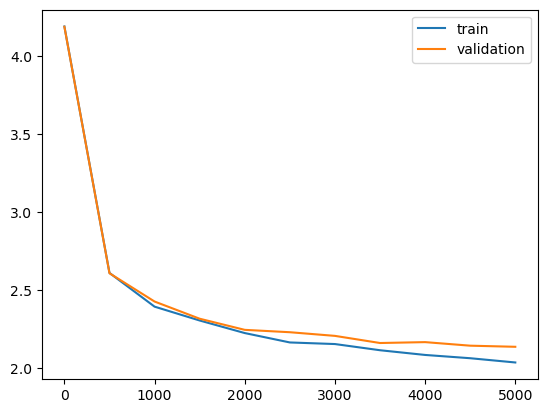

In [52]:
import matplotlib.pyplot as plt

plt.plot(range(0,len(train_loss)*500,500), train_loss, label='train')
plt.plot(range(0,len(train_loss)*500,500), validation_loss, label='validation')
plt.legend()
plt.show

In [53]:
# Generate from the model and save it to wave_net.txt.
# We generate a maximum of 1000 tokens. 
# We feed in a batch of dimenson (1, context_size).
# The loss should get to ~ 2.0 on train and validation.
# Unfortunately, this will likely not make much sense, the capacity of this model is not ideal for this task.
# The name generation task fro HW 1 might be aother data set to use.
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
if write_to_file:
    open('wave_net.txt', 'w').write(decode(model.generate(context, max_new_tokens=10000)[0].tolist()))

C:\Users\Alex\AppData\Local\Temp\ipykernel_4884\2409626403.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits) # (N, vocab_size)


First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
Hhy be whan: oheres nisternment oss;
AsG:?
Amhamchoad yemnce helf &ink
Yuon,
Whwase is father oRmits, stull:
Highhive tinliis'd for that ats roundounnhis thy duscewell,
And sty thy and of theing ibtleng 'ishhereindcheyaw mabe arom caw me anZun, Wpomeu; !
What ! yitleuny:
Mecitg henrafecovetolemale hwast ad rithew! wbatr then mestore;
Hast wherow profoll froue rame:
Imeldan, pees canreptel,
Thraance ohe you as wade anst in bed foreesi is these of thy theies.
Wguothis hiy oaintranrell.

SER'd chin


Bonus (+5 max - If you do this and it's all right this assignment will be 13/10.)
- Add some residual connections. Does this improve gradient zero issues?
 - Add some logging to figure out the number of zero gradients across the network before and after you add the residual connections.
- Add some plots that show the train and validation loss, per k iterations. You might want k < 500.
- Use LayerNorm instead of batch norm.
- Use the names.txt file from assignment 1. How do the names look?

### Name

In [54]:
with open('names.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [55]:
# Get all the unique characters in the text.                                                                                                             
chars = list(set(text))
vocab_size = len(list(set(text)))
# As usual, create a mapping from a character to a text.                                                                                                                            
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
# encode: is a lambda function that takes a string and returns  a list of ints, where each character is mapped to the right int.
encode = lambda x:[stoi[e] for e in x]
# decode: is the reverse mapping of encode. It takes a list of int, and returns a string.
decode = lambda x:''.join(itos[e] for e in x)

data = encode(text)
n = int(0.9*len(data)) # first 90% will be train, rest val                                                                                                                 
train_data = data[:n]
val_data = data[n:]

In [56]:
model = WaveNetMLPLanguageModel().to(device)
# Print the number of parameters in the model.
print(sum(p.numel() for p in model.parameters()) , 'M parameters')

# Create a PyTorch optimizer. Use AdamW.                                                                                                                                                                                                                                        
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

192194 M parameters


In [57]:
# Here we loop over max_iters and at each iter we get a batch of data we optimize over.
model.train()
train_loss = []
validation_loss = []
for epoch in range(epochs):

    # every once in a while evaluate the loss on train and val sets                                                                                                                                                                                                 
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        losses = estimate_loss()
        train_loss.append(losses['train'])
        validation_loss.append(losses['val'])
        print(f"step {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Sample a batch of data                                                                                                                                                                                                                                        
    xb, yb = get_batch('train')

    # evaluate the loss                                                                                                                                                                                                                                             
    logits, loss = model(xb, yb)
    # Zero the grads.
    optimizer.zero_grad()
    # Get gradients by backprop; do a parameter update.
    loss.backward()
    if epoch % eval_interval == 0 or epoch == epochs - 1:
        zero_grads_sum = 0
        for _, param in model.named_parameters():
            zero_grads_sum += sum(param.grad.ravel() == 0.0).item()
        print('Number of zero gradient parameters: ', zero_grads_sum)
    
    optimizer.step()

step 0: train loss 3.3056, val loss 3.3067
Number of zero gradient parameters:  9
step 500: train loss 2.3596, val loss 2.4678
Number of zero gradient parameters:  30
step 1000: train loss 2.2157, val loss 2.3104
Number of zero gradient parameters:  37
step 1500: train loss 2.1697, val loss 2.2491
Number of zero gradient parameters:  32
step 2000: train loss 2.1132, val loss 2.2078
Number of zero gradient parameters:  20
step 2500: train loss 2.0282, val loss 2.1389
Number of zero gradient parameters:  26
step 3000: train loss 2.0166, val loss 2.1255
Number of zero gradient parameters:  25
step 3500: train loss 1.9624, val loss 2.0556
Number of zero gradient parameters:  29
step 4000: train loss 1.9364, val loss 2.0473
Number of zero gradient parameters:  34
step 4500: train loss 1.9236, val loss 2.0143
Number of zero gradient parameters:  27
step 4999: train loss 1.8898, val loss 2.0171
Number of zero gradient parameters:  27


<function matplotlib.pyplot.show(close=None, block=None)>

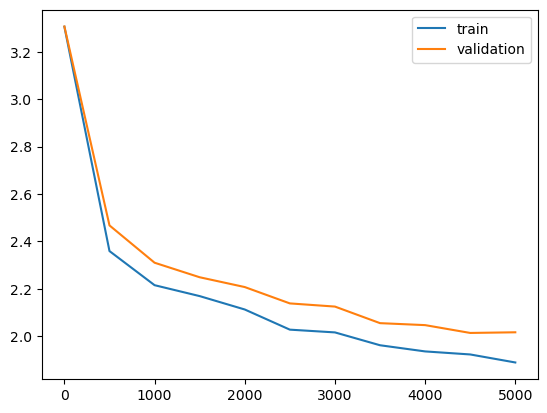

In [58]:
plt.plot(range(0,len(train_loss)*500,500), train_loss, label='train')
plt.plot(range(0,len(train_loss)*500,500), validation_loss, label='validation')
plt.legend()
plt.show

In [59]:
model.eval()
context = torch.tensor(train_data[:256]).reshape(1, 256)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


C:\Users\Alex\AppData\Local\Temp\ipykernel_4884\2409626403.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits) # (N, vocab_size)


emma
olivia
ava
isabella
sophia
charlotte
mia
amelia
harper
evelyn
abigail
emily
elizabeth
mila
ella
avery
sofia
camila
aria
scarlett
victoria
madison
luna
grace
chloe
penelope
layla
riley
zoey
nora
lily
eleanor
hannah
lillian
addison
aubrey
ellie
stella
naaina
nsadonita
anaya
anwy
nakese
naalee
naelah
rasena
nola
nanya
noyi
nazes
nafhanta
ziella
zynnhel
mayte
emiansler
balin
apheo
azer
caeal
emdhana
eljemie
dayia
emdan
rylen
elaira
inahan
onyliciara
matheyanee
nedom
naixia
paylee
tamilemi
malzer
vaydan
iayla
riiciiba
motheri
radenah
arelis
arletson
jenazes
dessayia
cialrea
siasewen
brayg
branenna
brester
yalie
yulmenit
alyto
eneomorah
emmie
aviophon
adglo
jiqn
kausnad
alaui
laiana
malee
macaedo
bmaerea
lahyah
makayas
makae
mabella
melea
nekiya
n
